# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
plt.rcParams['image.cmap'] = "gray"

In [30]:
from sklearn.model_selection import train_test_split


df = pd.read_excel('alldata.xlsx')
df = df.dropna()
labels = df['parti']
df = df.drop(columns=['storkreds', 'alder', 'navn', 'parti'])



from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
X_scaled= scaler.transform(df)

from sklearn.decomposition import PCA
# keep the first ten principal components of the data
pca = PCA(n_components = 10)
# fit PCA model to beast cancer data
pca.fit(X_scaled)

# transform data onto the first ten principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))


Original shape: (867, 49)
Reduced shape: (867, 10)


In [31]:
import numpy


print(f"The ratio of 10 components: {pca.explained_variance_ratio_}")
print(f"This is how much information is explained in those ten components: {numpy.sum(pca.explained_variance_ratio_)}")

The ratio of 10 components: [0.41737636 0.10259865 0.04976011 0.04300925 0.02932318 0.0237002
 0.01994451 0.01696801 0.0167179  0.01607303]
This is how much information is explained in those ten components: 0.7354712120119059


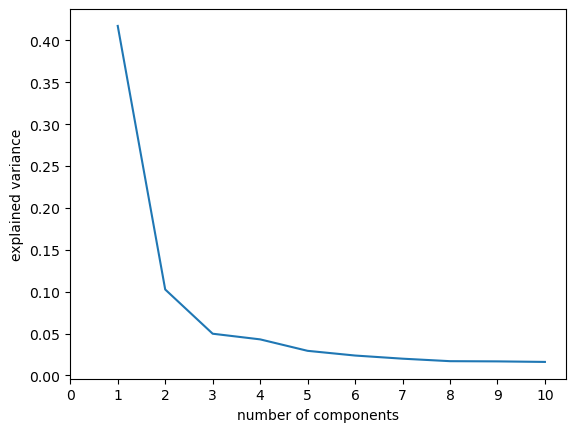

In [32]:
plt.plot(list(range(1, 1 + len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xticks(np.arange(0, 1 + len(pca.explained_variance_ratio_), step=1))
plt.show()

Text(0, 0.5, 'Second principal component')

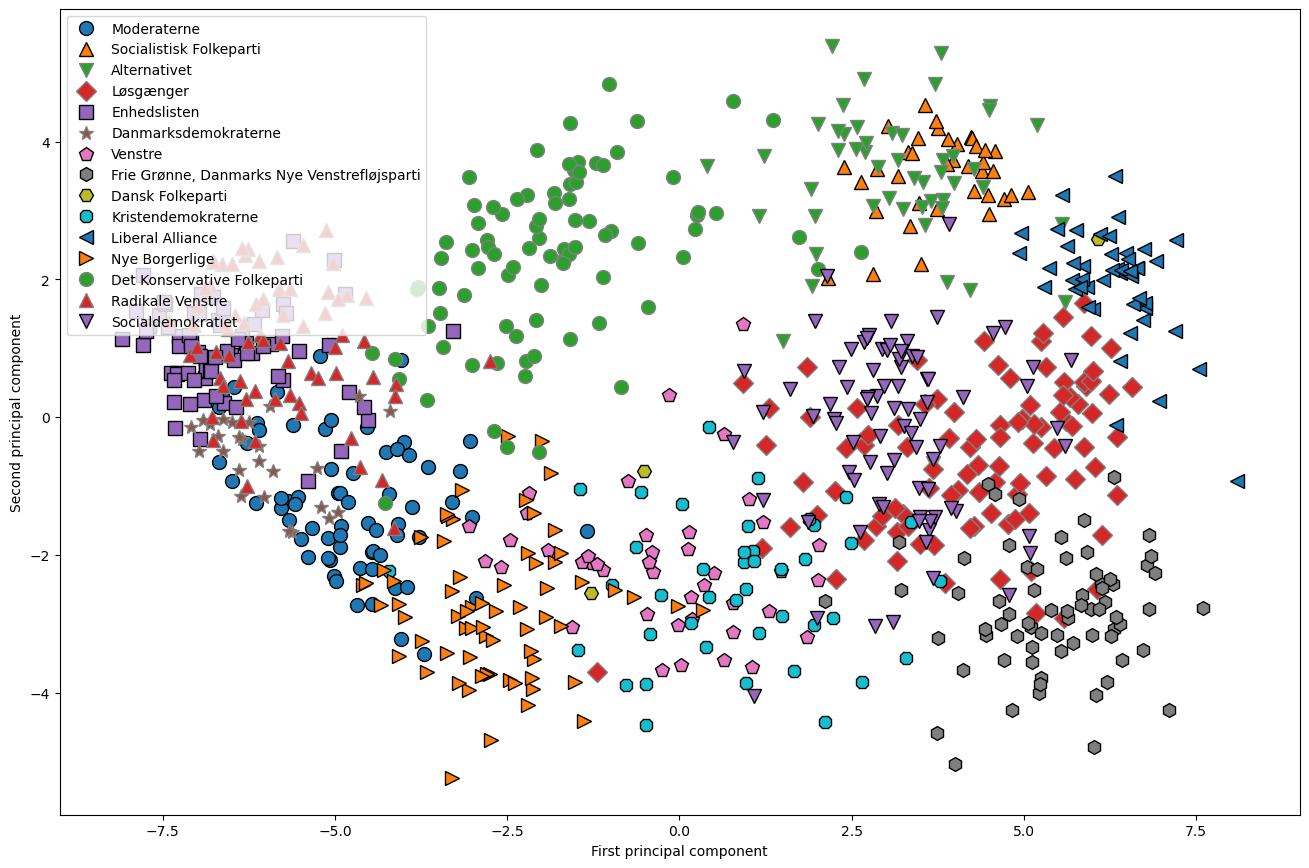

In [33]:
# plot first vs. second principal component, colored by class
plt.figure(figsize=(16, 16))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], labels)
plt.legend(labels.unique(), loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

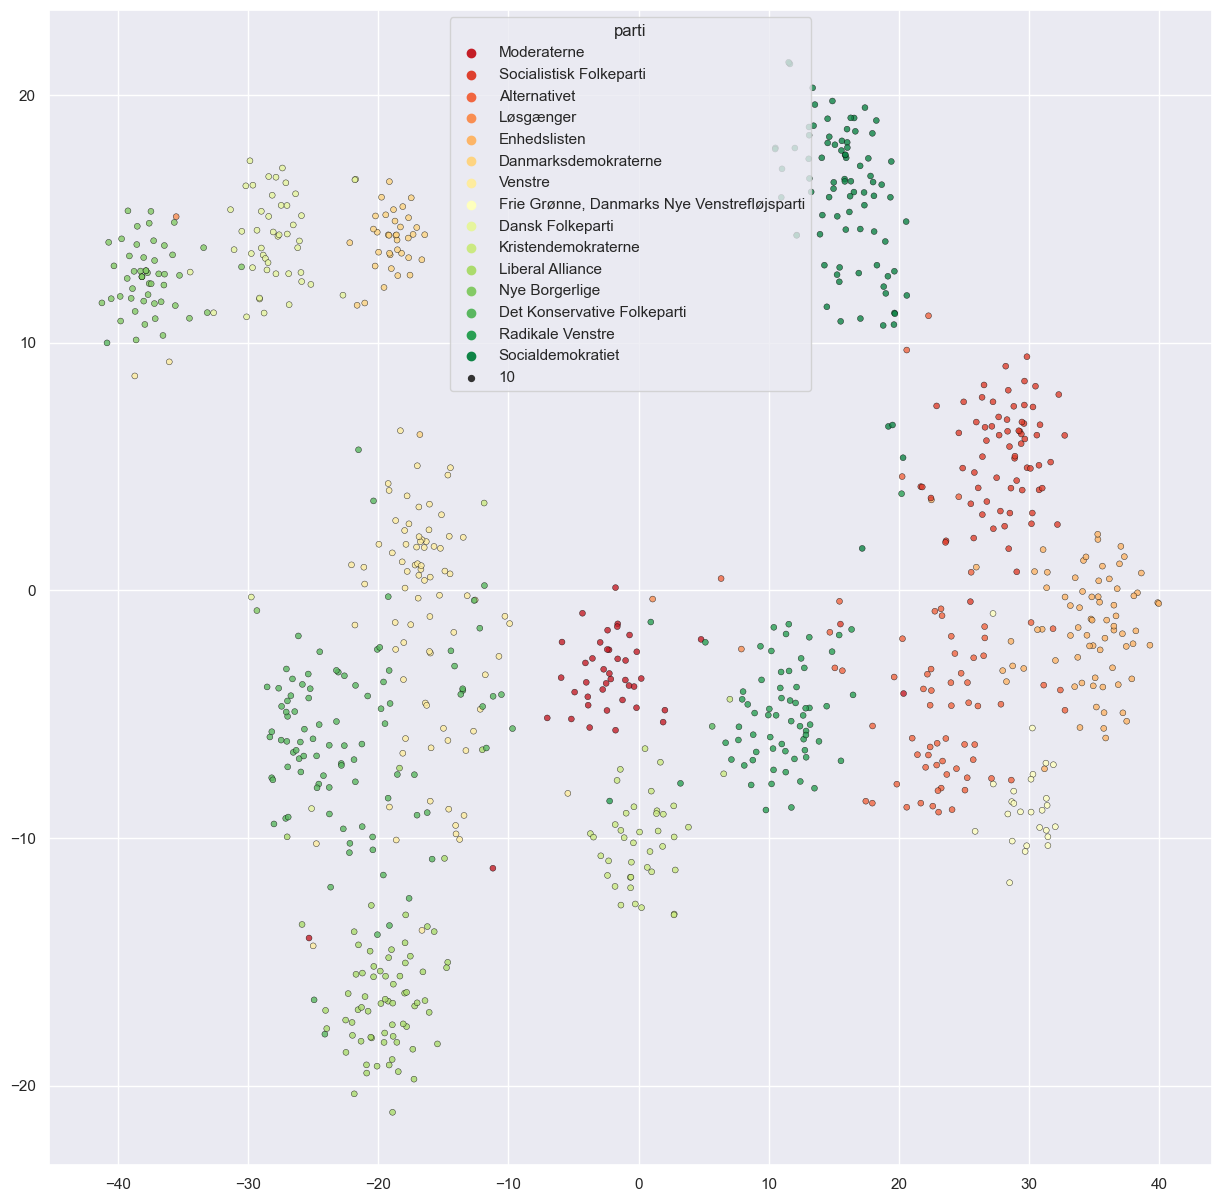

In [49]:
from matplotlib import colors
import seaborn as sns
from sklearn.manifold import TSNE
tsne = TSNE(perplexity= 30, random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
politcal_tsne = tsne.fit_transform(df)

def visualize_2d(x, labels):
    sns.set_theme(rc={'figure.figsize':(15,15)})
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, palette='RdYlGn', s=100, alpha=0.8, edgecolor="black", size=10)
    
visualize_2d(politcal_tsne, labels)